## Предобработка

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor, CatBoostClassifier
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE

In [159]:
df = pd.read_csv('final_df.csv')

In [160]:
df.loc[df['country'].isna(), 'country'] = 'Китай'
df.loc[~df['country'].isin(['Китай', 'Россия','Гонконг', 'Беларусь']), 'country'] = 'Другое'

pvh = []
for el in df['material']:
    if ('ПВХ' in el) or ('пвх' in el):
        pvh.append(1)
    else:
        pvh.append(0)
df['has_pvh'] = pvh

type_other = ['Игрушки-подвески', 'Магнитные доски', 'Пушкары', 'Рамки-вкладыши', 'Детские компьютеры',             
              'Домики для детей', 'Игрушечные гаражи', 'Лабиринты', 'Прыгунки', 'Пазлы', 'Сквиши']
df.loc[df['type'].isin(type_other), 'type'] = 'Другое'

df.loc[df['color'].isna(), 'color'] = 'Неизвестно'
df['color'] = df['color'].apply(lambda x: x.split(', ')[0])
df['color'] = df['color'].apply(lambda x: x.split('-')[-1])
df['color'] = df['color'].apply(lambda x: x.split()[0])
color_other = df['color'].value_counts().index[26:]
df.loc[df['color'].isin(color_other), 'color'] = 'Другое'

popular_brands = df['brand'].value_counts().index[:4]
df['brand_popular'] = df['brand'].isin(popular_brands) * 1
df['has_video'] = df['has_video'] * 1

df['is_verified'] = df['is_verified'] * 1
df['target'] = np.log(df['num_feedbacks']) * df['item_rating']
df['price'] = df['price'] / 100
df.drop(columns = ['brand', 'id', 'name', 'description', 'material', 'equipment',
                   'item_rating', 'img', 'num_feedbacks'], inplace = True)

In [161]:
X = df.drop(columns = 'target')
y = df['target']
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size = 0.3, random_state = 52)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size = 0.66, random_state = 52)

In [162]:
feature_cat = ['type', 'color', 'country', 'cluster']
feature_num = ['photo_count', 'supplier_rating', 'quantity', 
               'price', 'text_length', 'sentiment', 'rating']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, feature_cat)
    ],
    remainder='passthrough' 
)

train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
test = preprocessor.transform(X_test)

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(feature_cat)

all_feature_names = list(ohe_feature_names) + \
    list(X_train.drop(columns=feature_cat).columns)

X_train = pd.DataFrame(train, columns=all_feature_names, index=X_train.index)
X_val = pd.DataFrame(val, columns=all_feature_names, index=X_val.index)
X_test = pd.DataFrame(test, columns=all_feature_names, index=X_test.index)

## Оценка моделей

### Регрессия

In [7]:
from sklearn.metrics import mean_absolute_percentage_error

In [8]:
def get_metrics_regression(true, pred):
    mse = ((pred - true) ** 2).mean()
    mae = np.abs(pred - true).mean()
    mape = mean_absolute_percentage_error(true, pred)
    
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    return mse, mae, mape

Сначала наивный прогноз в виде среднего

In [9]:
pred_naive = [y_train.mean()] * len(y_test)
mse_naive, mae_naive, mape_naive = get_metrics_regression(y_test, pred_naive)

MSE: 44.35196239423059
MAE: 5.336948441151827
MAPE: 0.16304113325539438


Случайный лес

In [10]:
def objective_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 200, 700)
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt']) 
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
     
    model = RandomForestRegressor( n_estimators = n_estimators, max_features = max_features, 
                                  min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    score = np.abs(y_val - pred_val).mean()
    
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective_forest, n_trials=25)
best_params_forest = study.best_params

In [11]:
forest = RandomForestRegressor(**best_params_forest, random_state = 52)
forest.fit(X_train, y_train)

pred_forest = forest.predict(X_test)
mse_forest, mae_forest, mape_forest = get_metrics_regression(y_test, pred_forest)

MSE: 26.135545392065303
MAE: 3.9635018835969515
MAPE: 0.12377878525500714


Бустинг

In [68]:
model_cat = CatBoostRegressor(bootstrap_type = 'MVS', n_estimators = 600, max_depth = 10, random_state = 52,
                             mvs_reg = 20)
model_cat.fit(X_train, y_train, verbose = False)

pred_cat = model_cat.predict(X_test)
mse_cat, mae_cat, mape_cat = get_metrics_regression(y_test, pred_cat)

MSE: 24.03991859370434
MAE: 3.7527251087733946
MAPE: 0.11714325924770888


### Классификация

Делим целевую переменную на 2 класса: успешный и неуспешный

''

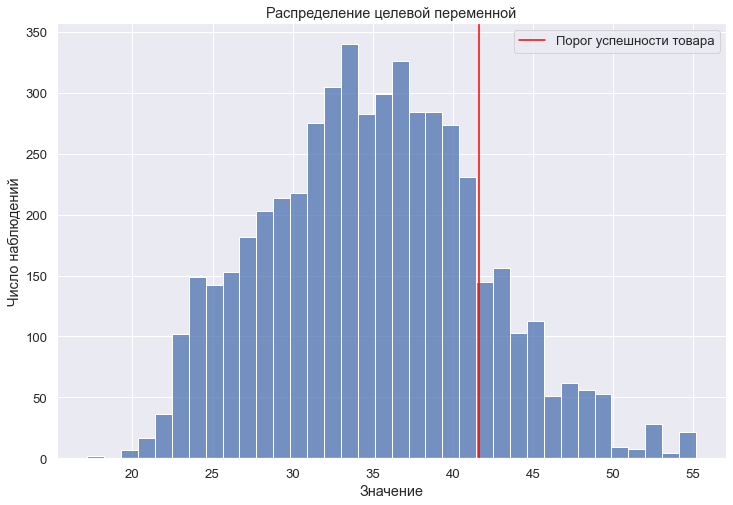

In [220]:
sns.set(font_scale = 1.2)
plt.figure(figsize = (12, 8))

plt.title('Распределение целевой переменной')
plt.xlabel('Значение')
plt.ylabel('Число наблюдений')
plt.axvline(x = df['target'].mean() + df['target'].std(), color = 'red', label = 'Порог успешности товара')
plt.legend()
sns.histplot(df['target'])
;

In [163]:
# преобразуем переменные
bound = 41
y_train = (y_train > 41) * 1
y_val = (y_val > 41) * 1
y_test = (y_test > 41) * 1

In [164]:
def get_metrics_class(true, pred, pred_proba):
    acc = accuracy_score(true, pred)
    roc_auc = roc_auc_score(true, pred_proba)
    auc_pr = average_precision_score(true, pred_proba)
    
    print(f'Accuracy: {acc}')
    print(f'ROC-AUC: {roc_auc}')
    print(f'AUC-PR: {auc_pr}')
    return acc, roc_auc, auc_pr

In [201]:
print(f'Доля самого популярного класса: {1 - y_test.mean()}')

Доля самого популярного класса: 0.8222003929273085


In [200]:
model_cat = CatBoostClassifier(random_state = 52, bootstrap_type = 'MVS', n_estimators = 600, 
                              max_depth = 10, rsm = 0.8)
model_cat.fit(X_train, y_train, verbose = False)

pred_cat_proba = model_cat.predict_proba(X_test)[:, 1]
pred_cat = 1 * (pred_cat_proba > 0.5)

acc, roc_auc, auc_pr = get_metrics_class(y_test, pred_cat, pred_cat_proba)

Accuracy: 0.9017681728880157
ROC-AUC: 0.9115824075724273
AUC-PR: 0.7782485449324088


''

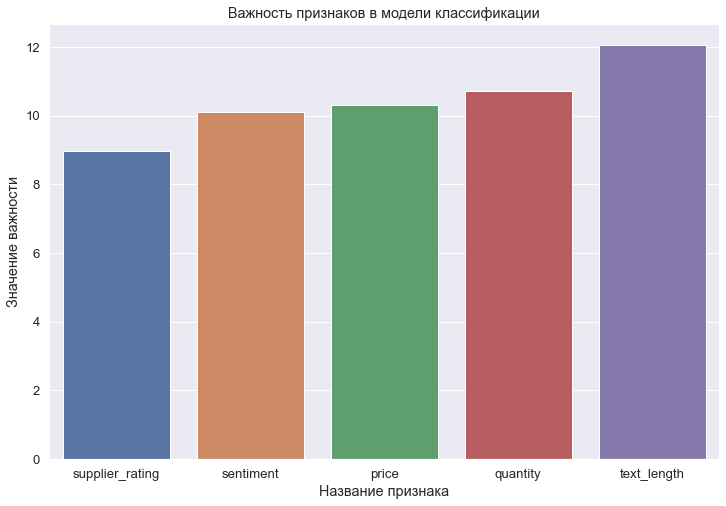

In [219]:
most_important = model_cat.feature_importances_.argsort()[-5:]
var_imp = model_cat.feature_importances_[most_important]
var_names = X_train.columns[most_important]

plt.figure(figsize = (12, 8))
plt.title('Важность признаков в модели классификации')
plt.xlabel('Название признака')
plt.ylabel('Значение важности')
sns.barplot(x = list(var_names.values), y = var_imp)
;